In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **FIMO**
-  Searches sequences for individual matches to motifs
    -  Input motifs are those discovered by MEME & DREME
- Results from **FIMO, MEME, & DREME** are aggregated here
    - All results have corrected p-values < 0.05
    - Only MEME & DREME motifs also found by FIMO are included in this report
- No. of FIMO matches to motifs are counted, q-values and scores for each motif are averaged

In [2]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [3]:
def motif_lookup(db):
    
    with open("./pipeline.ini", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [4]:
def meme_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples
                
    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:

                    # get corresponding meme e_values for discovered motifs from meme.txt
                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                        meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Meme_tomtom"
                        meme_out = "meme.chip.dir/" + name + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    
                    if os.path.exists(meme_out):
                        n = 0
                        with open(meme_out, "r") as open_meme:
                            for line in open_meme:
                                motif = re.findall("^MOTIF.*", line)
                                if len(motif) > 0:
                                    n = n + 1
                                    nmotif = str(motif[0].split(" ")[0:3][-1])
                                e_val = re.findall("E-value.*", str(motif))
                                if len(e_val) > 0:
                                    e_value = e_val[0].split(" ")[-1].replace("'", "").strip("]")

                                if (len(e_val)>0) & (len(motif) > 0):
                                    df = pd.DataFrame([nmotif, e_value]).transpose()
                                    df.columns = ["query_id", "meme_evalue"]
                                    df["run"] = str(table).rstrip("_Meme_tomtom")
                                    dfs.append(df)
    c = 0
    for df in dfs:
        c = c + 1
        if c ==1:
            motifs = df
        else:
            motifs = motifs.append(df)

    motifs = motifs.drop_duplicates()
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("meme_motifs", connect, if_exists="replace", index=False)
                    
    return motifs

meme = meme_summary(db)

In [5]:
def memechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples
        
    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:

                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Meme_tomtom"

                    if tables["tables"].str.contains(table).any():
                        
                        n = 0
                        for query in no_motifs:
                            n = n + 1
                            statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                        b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                        from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                        and a.query_id = %(query)s 
                                        order by e_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df = df.drop_duplicates()
                            df["run"] = str(table).rstrip("_Meme_tomtom")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            
                            if c != None: 
                                df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                                df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                                df["window"] = df["run"].apply(lambda x: x.split("_")[3])
                            else:
                                df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[1])
                                df["window"] = df["run"].apply(lambda x: x.split("_")[2])


                            if n == 1:
                                result = df
                            else:
                                result = result.append(df)

                        dfs.append(result)
                        
    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

meme_motifs = memechip_summary(db)

In [6]:
def analyse_meme(motifs, meme):

    # annotate dfs for merging
    motifs["merge"] = motifs.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)
    meme["merge"] = meme.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)

    meme.drop(["query_id", "run"], axis=1, inplace=True) # drop extra cols

    # merge dfs
    meme_chip = pd.merge(meme, motifs, how="inner", on="merge")
    meme_chip.drop_duplicates(inplace=True)

    meme_chip["meme_evalue"] = meme_chip["meme_evalue"].apply(lambda x: float(x)) # correct type
    meme_chip["settings"] = meme_chip["no_peaks"] + "_" + meme_chip["window"] # make column for plot annotations

    if len(meme_chip[meme_chip["meme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        meme_chip = None

    else:
        # subset on sig motifs & sig matches
        meme_chip = meme_chip[(meme_chip.tomtom_evalue < 0.05) & (meme_chip.meme_evalue < 0.05)].sort_values(["meme_evalue", "tomtom_evalue"], ascending=True)
        meme_chip = meme_chip[meme_chip["meme_evalue"] != 0]
        meme_chip = meme_chip[meme_chip["tomtom_evalue"] != 0]

    return meme_chip

meme_chip = analyse_meme(meme_motifs, meme)

In [7]:
def dreme_summary(db, conditions="", widths="", no_peaks="", samples=""):

    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)
        
    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    df = []
    n = 0
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:

                    # get corresponding meme e_values for discovered motifs from meme.txt
                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"
                        meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Dreme_tomtom"
                        meme_out = "meme.chip.dir/" + name + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                
                    if os.path.exists(meme_out):
                        with open(meme_out, "r") as open_meme:
                            l = 0
                            for line in open_meme:
                                motif = re.findall("^#.*", line)
                                if len(motif) > 0:
                                    l = l + 1
                                    if l > 6:
                                        motif =  [ x for x in motif if "Stopping" not in x]
                                        motif =  [ x for x in motif if "Running" not in x]
                                        motif =  [ x for x in motif if "Word" not in x]
                                        if len(motif) > 0:
                                            motif = [x for x in ''.join(motif).split() if x not in ["BEST", "#"]]
                                            motif.append(table.replace("_Dreme_tomtom", ""))
                                            df.append(motif)

    df = pd.DataFrame(df, columns = ["motif", "motif_rc", "pos", "neg", "p_value", "dreme_evalue", "run"])
    df.drop("p_value", inplace=True, axis=1)
#     df = df.drop_duplicates()

    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("dreme_motifs", connect, if_exists="replace", index=False)

    return df

dreme = dreme_summary(db)

In [8]:
def dremechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Dreme_tomtom"


                    if tables["tables"].str.contains(table).any():

                        statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                    b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                    from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                    order by e_value asc''' % locals()

                        df = DB.fetch_DataFrame(statement, db)
                        df = df.drop_duplicates()
                        df["run"] = str(table).replace("_Dreme_tomtom", "")
                        df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                        if c != None: 
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])
                        else:
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[2])

                        dfs.append(df)

    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
        motifs.head()
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

dreme_motifs = dremechip_summary(db)

In [9]:
dreme_motifs.head()
dreme.head()

,query_id,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,run,DESeq2_comparison,no_peaks,window
0,GTGACR,GTGACA,M00985,Stra13,transfac,0.831647,-,group1_100_200,group1,100,200
1,GTGACR,GTGACA,M00985,Stra13,jaspar,0.831647,-,group1_100_200,group1,100,200
2,GTGACR,GTGACA,M00985,Stra13,uniprobe,0.831647,-,group1_100_200,group1,100,200
0,TGACTCA,TGACTCA,SMRC1_MOUSE.H10MO.B,SMRC1,hocomoco,0.007378,-,group1_500_100,group1,500,100
1,TGACTCA,TGACTCA,BATF_MOUSE.H10MO.B,BATF,hocomoco,0.009837,-,group1_500_100,group1,500,100


,motif,motif_rc,pos,neg,dreme_evalue,run
0,GTGACR,YGTCAC,34,7,2.7e-002,group1_100_200
1,GTGACG,CGTCAC,17,2,4.1e+000,group1_100_200
2,GTGACA,TGTCAC,18,5,6.7e+001,group1_100_200
3,TGACTCA,TGAGTCA,24,1,1.2e-002,group1_500_100
4,TGACTCA,TGAGTCA,24,1,1.2e-002,group1_500_100


In [10]:
def analyse_dreme(motifs, dreme):

    # reformat dfs for merge
    motifs.rename(columns={"query_id":"motif"}, inplace=True)

    # merge dfs
    dreme_chip = pd.merge(dreme, motifs, how="inner", on=["run", "motif"])
    dreme_chip.drop_duplicates(inplace=True)

    dreme_chip["dreme_evalue"] = dreme_chip["dreme_evalue"].apply(lambda x: float(x)) # correct type
    dreme_chip["settings"] = dreme_chip["no_peaks"] + "_" + dreme_chip["window"] # make column for plot annotations

    if len(dreme_chip[dreme_chip["dreme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        dreme_chip = None

    else:
        # subset on sig motifs & sig matches
        dreme_chip = dreme_chip[(dreme_chip.tomtom_evalue < 0.05) & (dreme_chip.dreme_evalue < 0.05)].sort_values(["dreme_evalue", "tomtom_evalue"], ascending=True)
        dreme_chip = dreme_chip[dreme_chip["dreme_evalue"] != 0]
        dreme_chip = dreme_chip[dreme_chip["tomtom_evalue"] != 0]

    return dreme_chip

dreme_chip = analyse_dreme(dreme_motifs, dreme)

In [11]:
def fimo_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
        
                    if c != None:
                        fimo = '_'.join([name, c, str(peaks), str(width)]) + "_fimo_summary"
                    else:
                        fimo = '_'.join([name, str(peaks), str(width)]) + "_fimo_summary"

                    if tables["tables"].str.contains(fimo).any():
                            statement = '''select matched_sequence as query_consensus, pattern_name as motif, q_value as fimo_qvalue, 
                                            score as fimo_score, sequence_name, start, stop, strand as orientation
                                            from %(fimo)s where q_value < 0.05 order by q_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df["run"] = str(fimo).rstrip("_fimo_summary")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            if c != None: 
                                df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                                df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                                df["window"] = df["run"].apply(lambda x: x.split("_")[3])
                            else:
                                df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[1])
                                df["window"] = df["run"].apply(lambda x: x.split("_")[2])

                            dfs.append(df)

    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            fimo = df
        else:
            fimo = fimo.append(df)

    fimo = fimo[fimo["fimo_qvalue"] != 0]
    
    return fimo

fimo = fimo_summary(db)

In [12]:
dreme_chip_fimo = pd.merge(fimo.drop_duplicates(), dreme_chip, how="inner", on=["run", "motif", "query_consensus", "orientation", "DESeq2_comparison", "no_peaks", "window"])

dreme_chip_fimo = dreme_chip_fimo.groupby(["query_consensus", "motif", "orientation", "dreme_evalue", "tomtom_evalue", 
                        "target_id", "motif_name", "database", "DESeq2_comparison", "run", 
                         "settings"]).agg({"fimo_qvalue":"mean", "fimo_score":"mean", "sequence_name":"count"})

dreme_chip_fimo.reset_index(inplace=True)

In [13]:
meme_chip_fimo = pd.merge(fimo.drop_duplicates(), meme_chip.rename(columns={"query_id":"motif"}), how="inner", on=["run", "motif", "query_consensus", "orientation", "DESeq2_comparison", "no_peaks", "window"])

meme_chip_fimo = meme_chip_fimo.groupby(["query_consensus", "motif", "orientation", "meme_evalue", "tomtom_evalue", 
                        "target_id", "motif_name", "database", "DESeq2_comparison", "run", 
                         "settings"]).agg({"fimo_qvalue":"mean", "fimo_score":"mean", "sequence_name":"count"})

meme_chip_fimo.reset_index(inplace=True)

In [14]:
dreme_chip_fimo["motif_discovery"] = "DREME"
dreme_chip_fimo.rename(columns={"dreme_evalue":"motif_discovery_evalue"}, inplace=True)

meme_chip_fimo["motif_discovery"] = "MEME"
meme_chip_fimo.rename(columns={"meme_evalue":"motif_discovery_evalue"}, inplace=True)

fimo_chip = dreme_chip_fimo.append(meme_chip_fimo)
fimo_chip.reset_index(inplace=True)

In [15]:
# make extra cols for annotation
fimo_chip["width"] = fimo_chip["settings"].apply(lambda x: "width_" + x.split("_")[1])
fimo_chip["peaks"] = fimo_chip["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])
# fimo_chip.head()

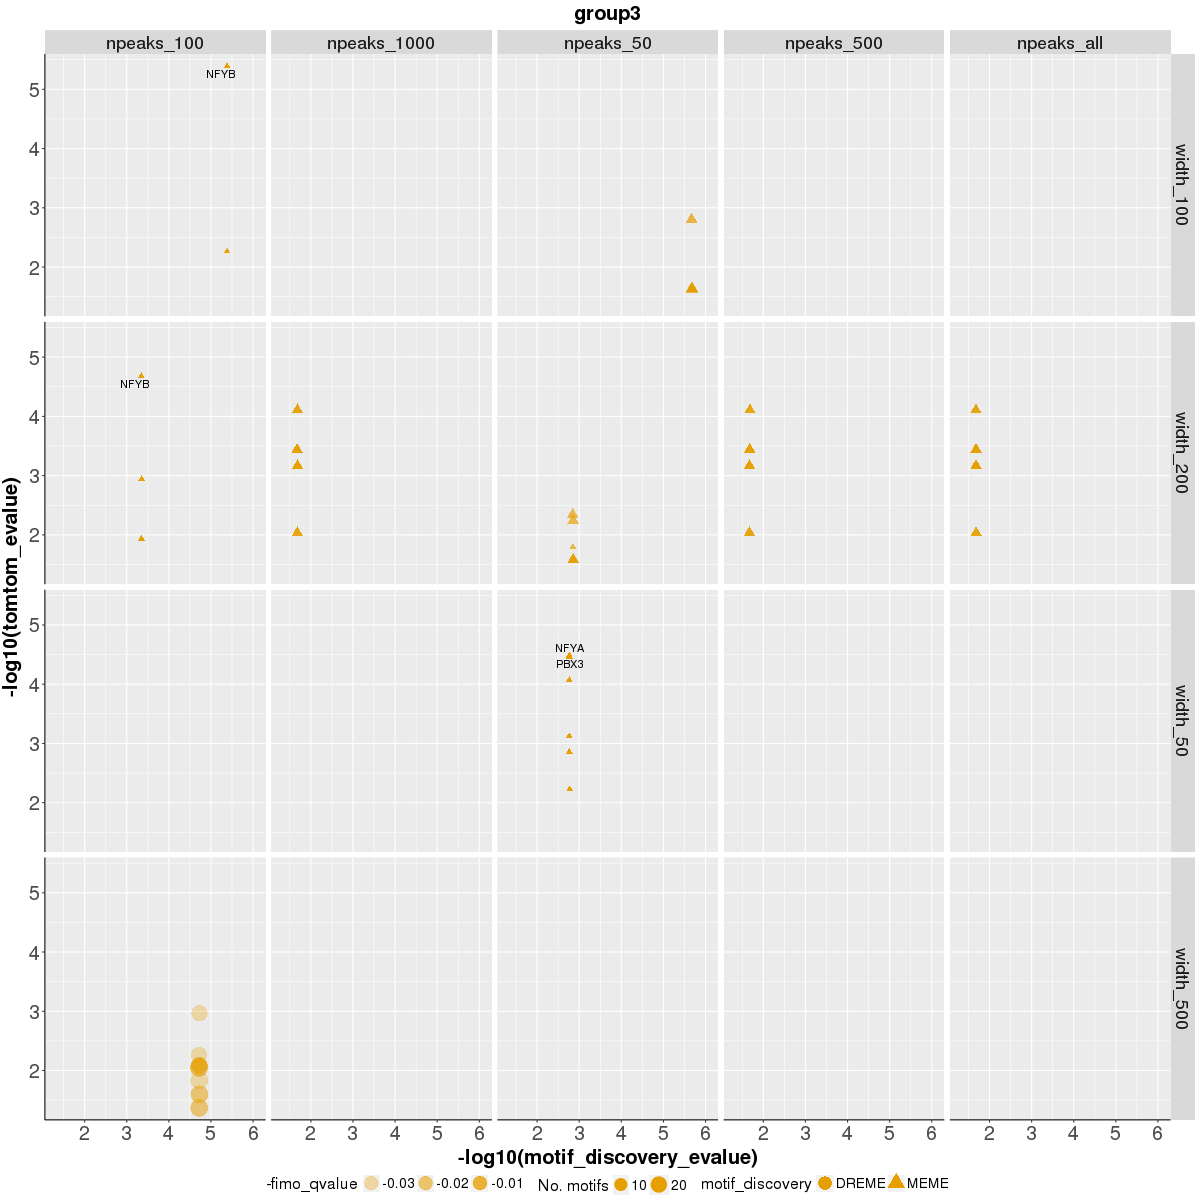

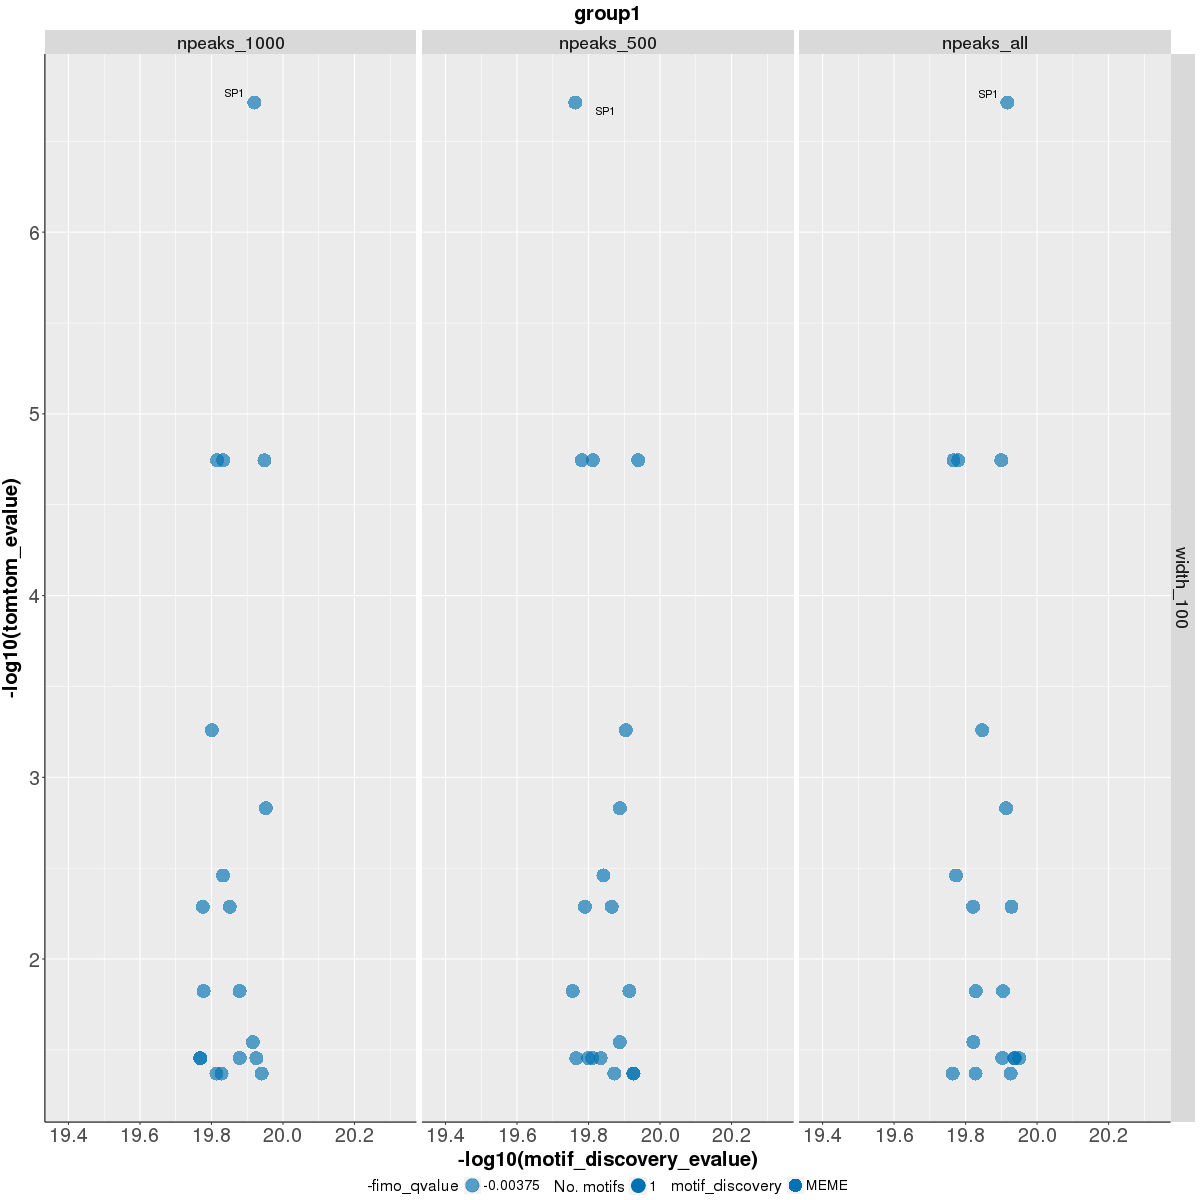

In [16]:
%%R -i fimo_chip -w 1200 -h 1200

n = 0
for (comp in unique(fimo_chip$DESeq2_comparison)){
    n = n +1
    df <- subset(fimo_chip, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(motif_discovery_evalue), 
                        shape=motif_discovery, alpha=-fimo_qvalue)) +
        geom_point(aes(size=sequence_name), position=position_jitterdodge(), colour=Palette[[n]]) + 
        scale_size(range=c(2,8), name="No. motifs") +
        scale_alpha(range=c(0.3,1)) +
        geom_text_repel(data=df[-log10(df$tomtom_evalue) > 
                                       quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=-log10(motif_discovery_evalue), label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=6))) +
        guides(alpha=guide_legend(override.aes=list(size=6)))  +
        guides(shape=guide_legend(override.aes=list(size=6)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

***
<br>
### Top TF Matches for Motifs
- The top 5 database TF matches for each motif (discovered by MEME or DREME and found in input sequences by FIMO) are shown
- Numbers over bars indicate the number of instances in which the motif is found by FIMO in the input sequences

In [42]:
tfs = fimo_chip.groupby(["motif", "DESeq2_comparison", "motif_discovery_evalue", "tomtom_evalue", 
                         "fimo_qvalue", "settings", "sequence_name"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs = tfs.groupby(["motif", "settings"]).head(5) # get top 5 db matches for each discovered motif
tfs["motif"] = tfs["motif"].astype(str)

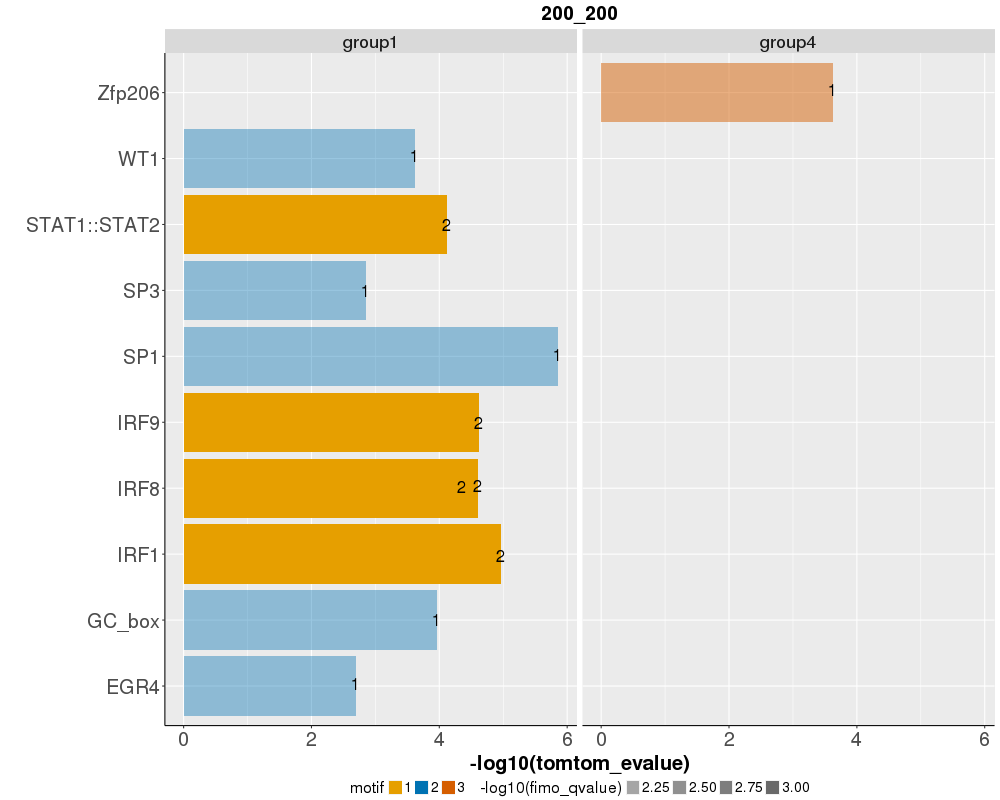

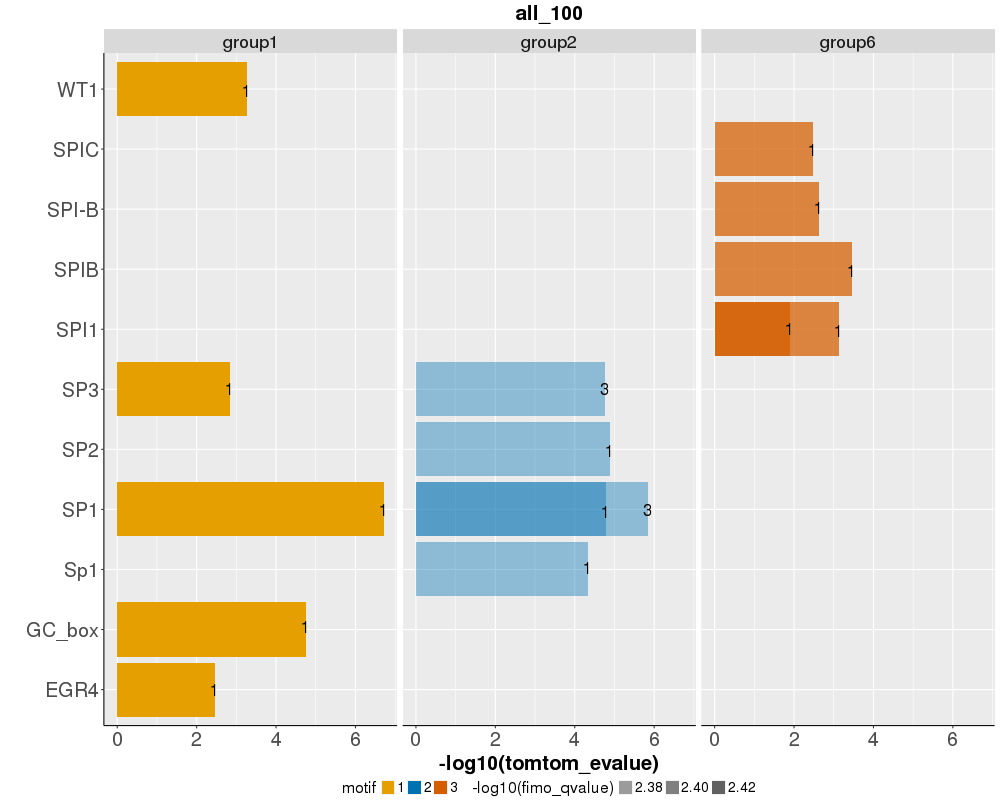

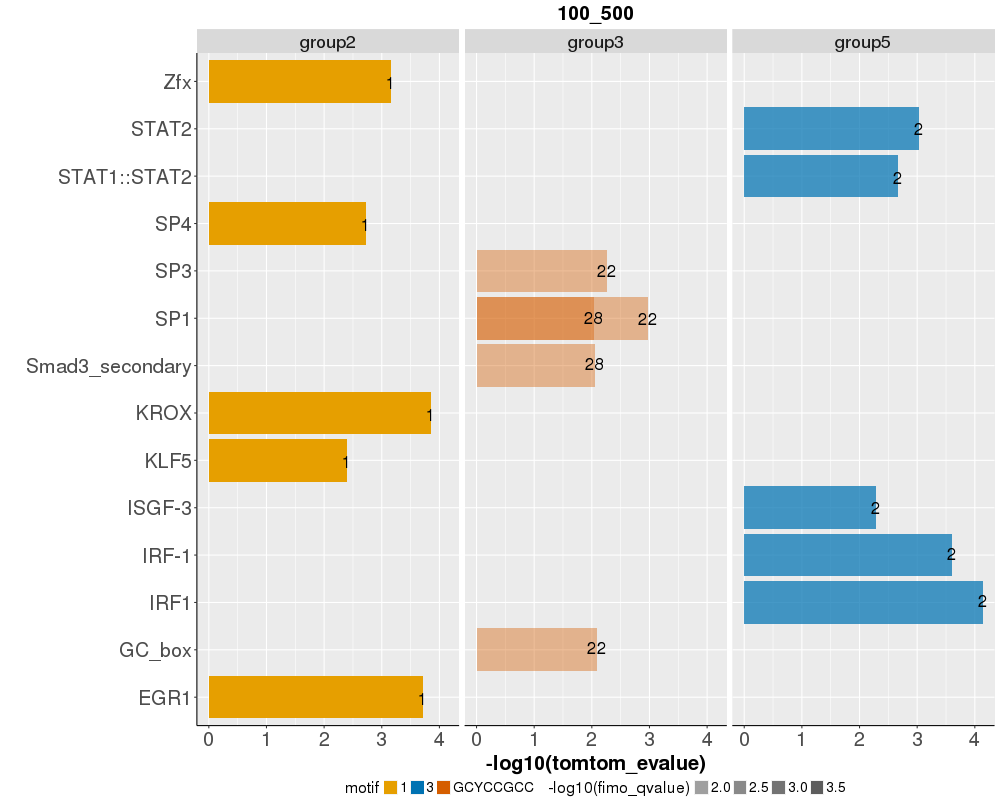

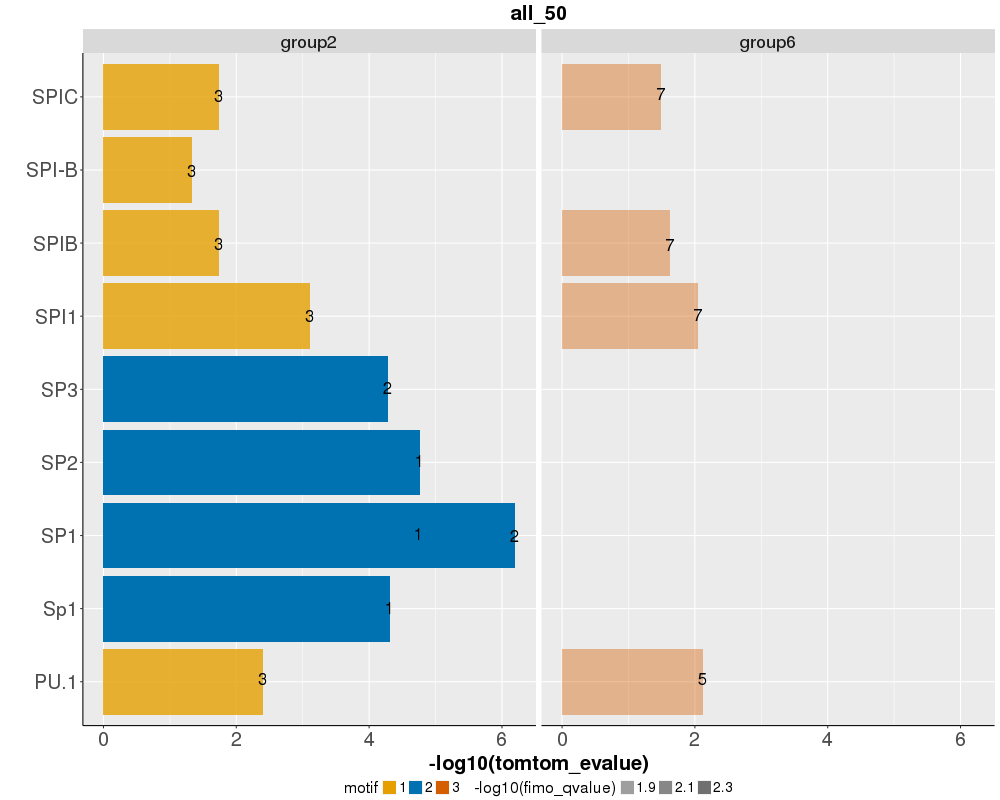

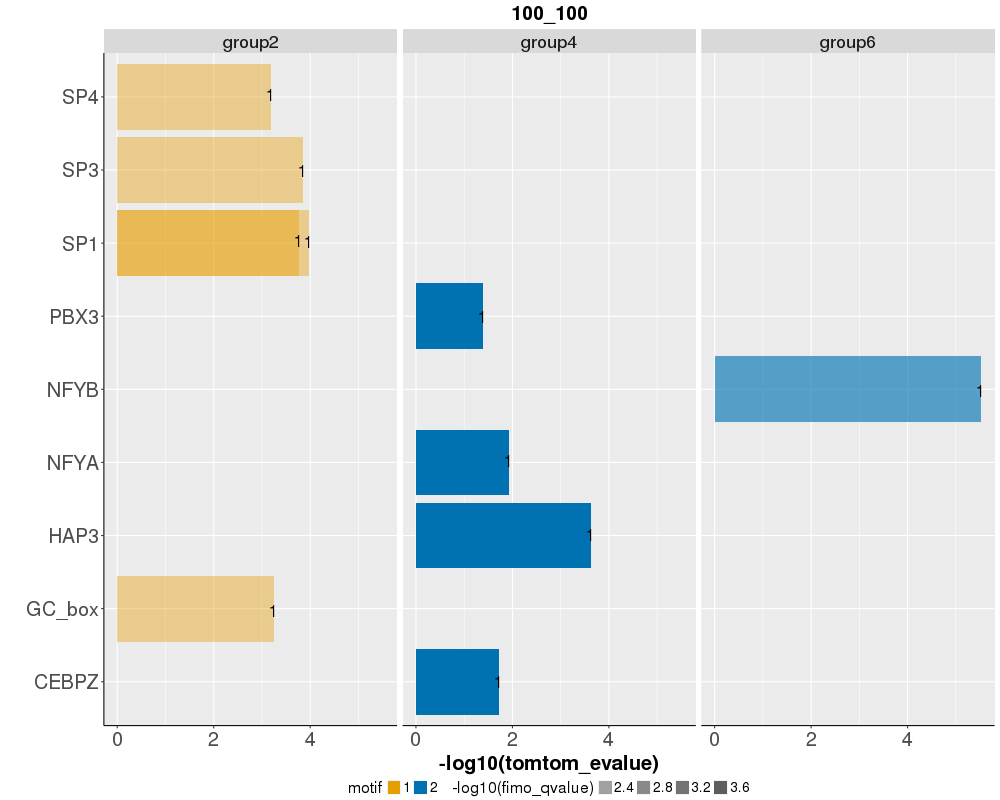

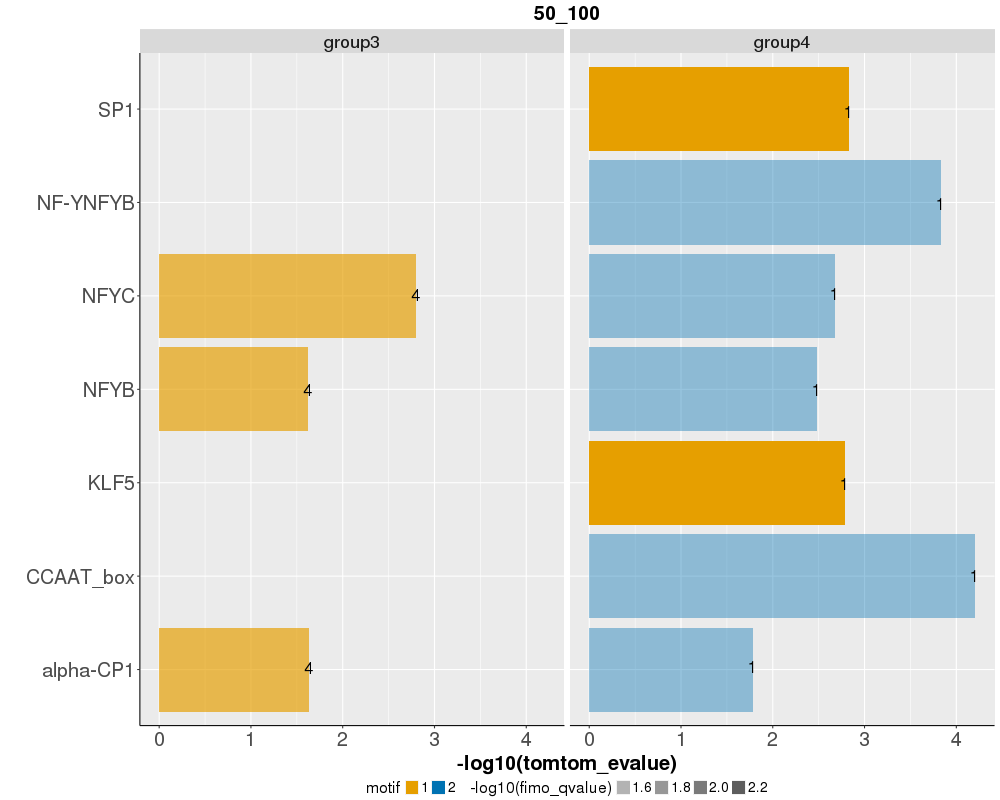

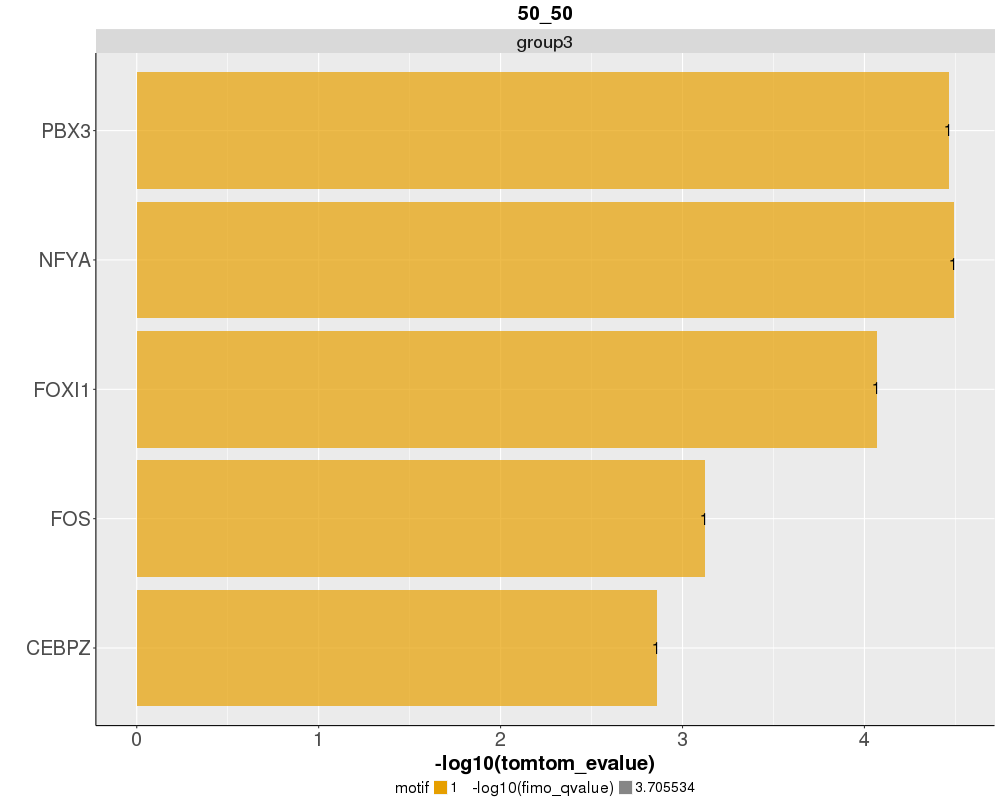

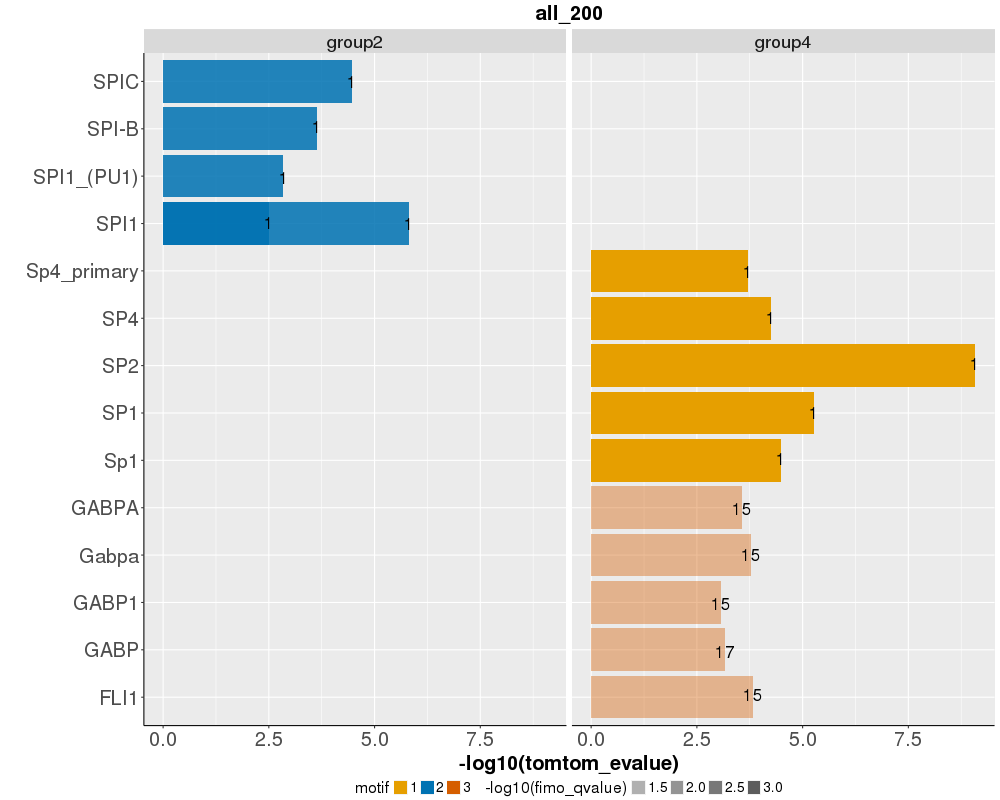

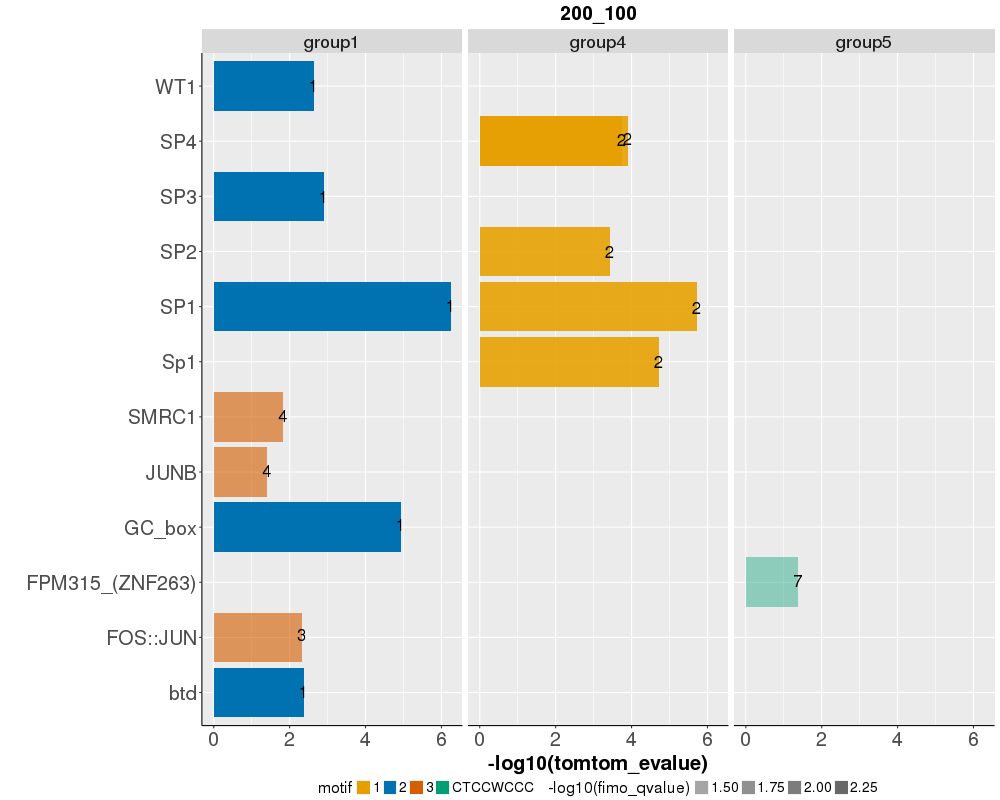

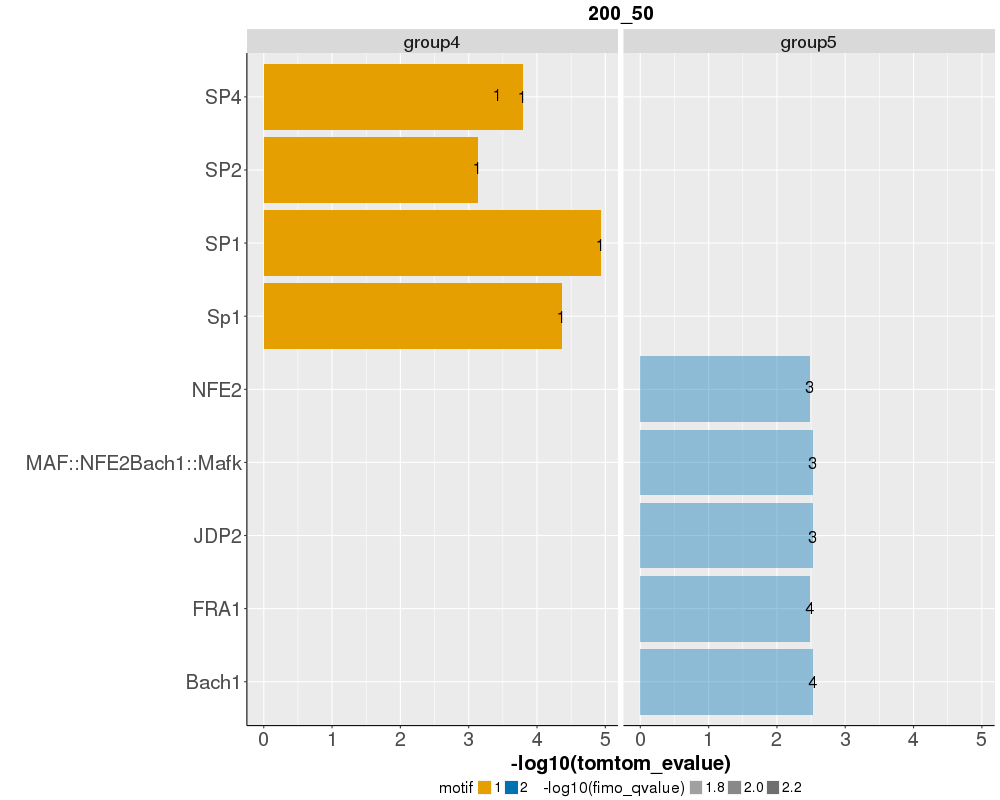

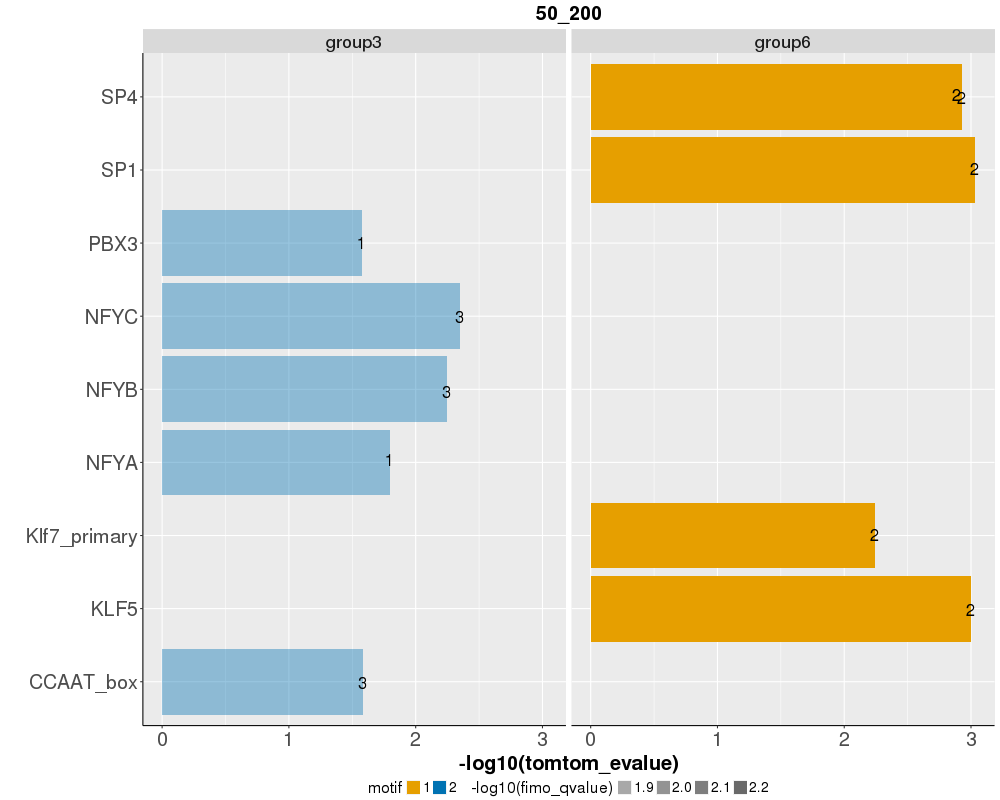

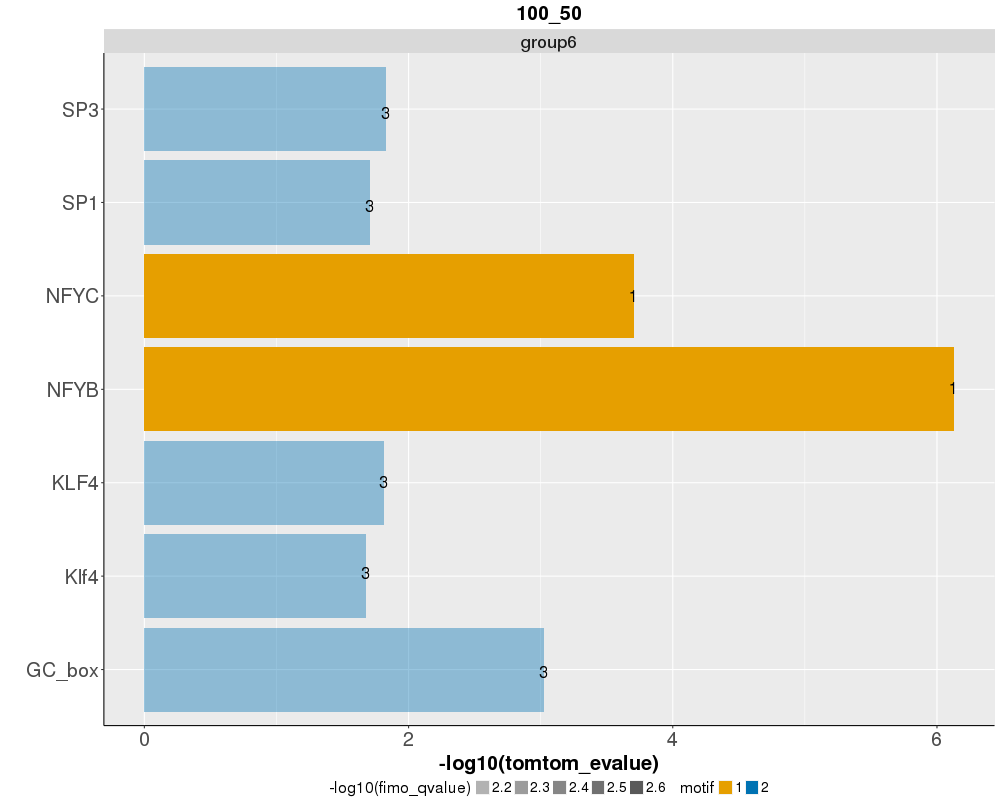

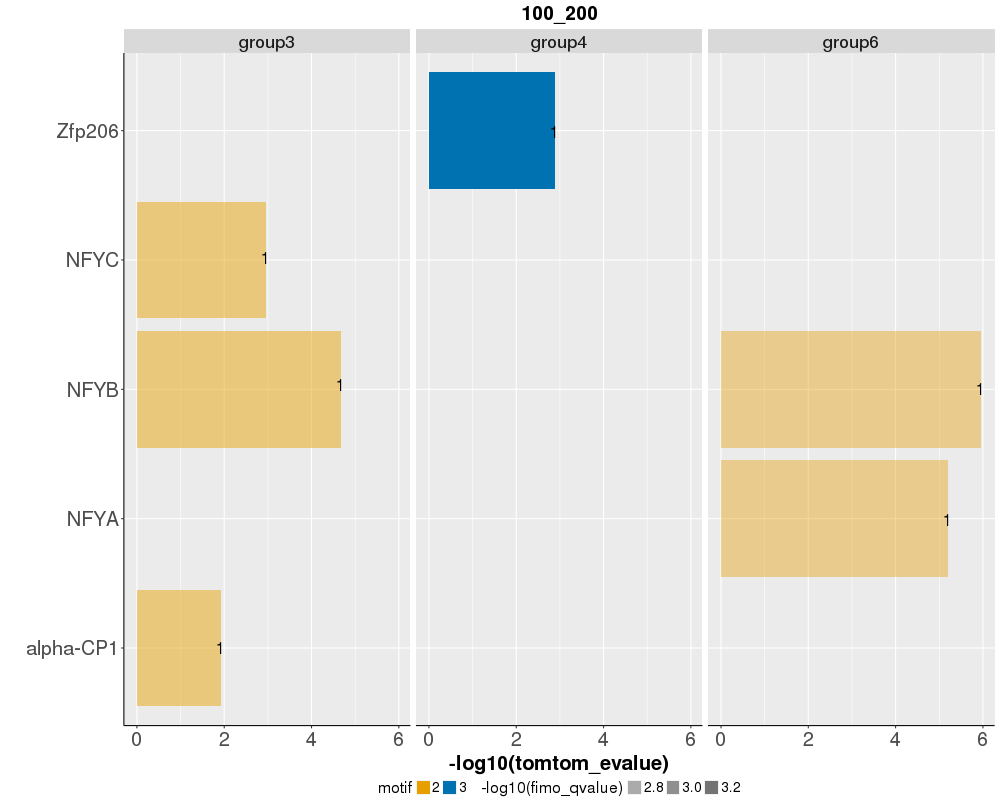

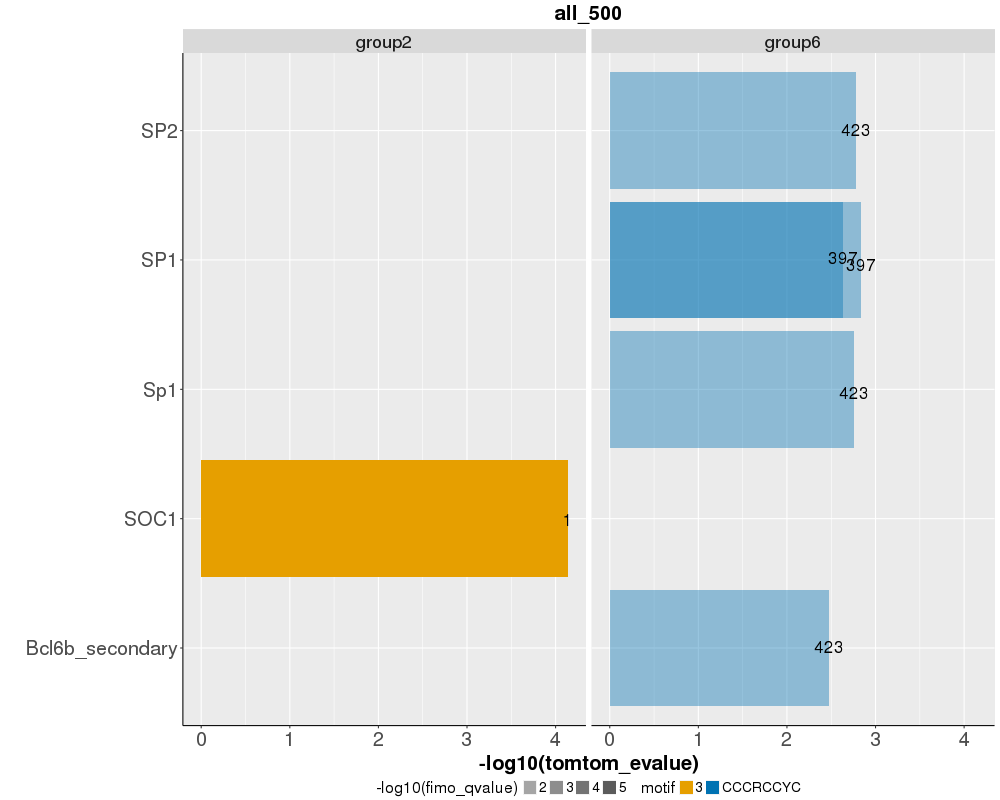

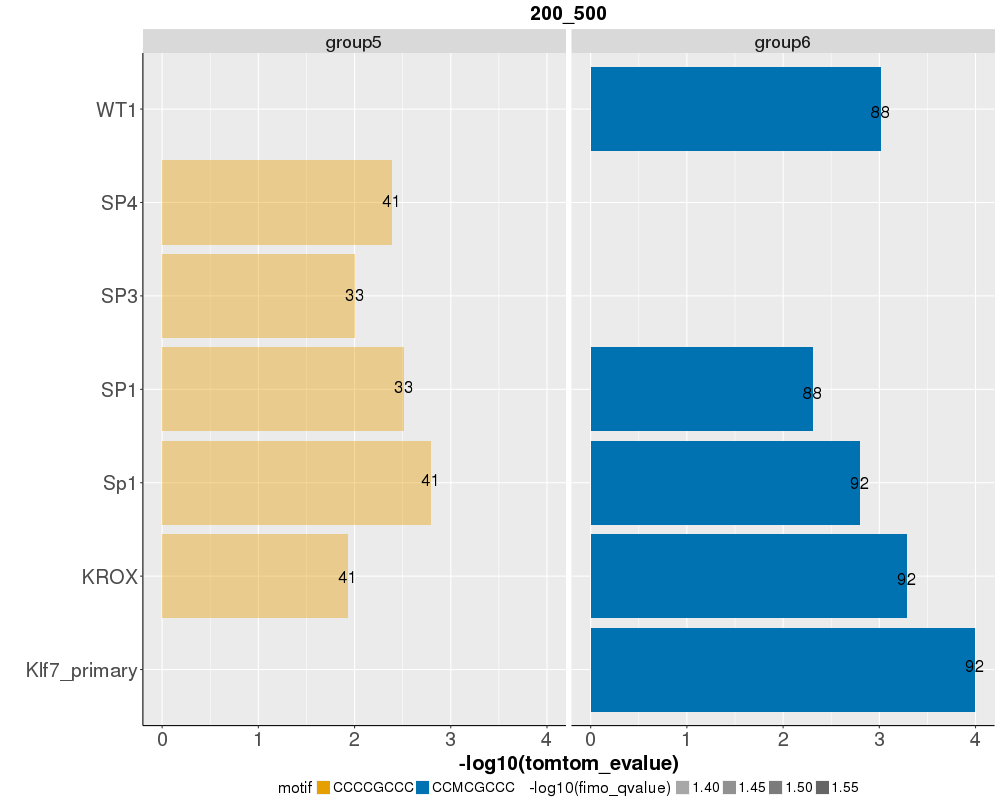

In [50]:
%%R -i tfs -w 1000 -h 800

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=motif, alpha=-log10(fimo_qvalue))) + 
            geom_bar(stat="identity", position="dodge") + 
            geom_text(aes(label=sequence_name), size=6, alpha=1, position=position_jitterdodge(dodge.width=0.5)) +
            coord_flip() +
            scale_alpha(range=c(0.4,1 )) +
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            scale_fill_manual(values=Palette) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}

<br>
## Top Motif Tables:
* sorted by fimo q-value

In [22]:
if "condition" in fimo_chip.columns:
    for i in fimo_chip["DESeq2_comparison"].unique():
        print i + " - Peaks with increased accessibility"
        fimo_chip[(fimo_chip.DESeq2_comparison == i) & (fimo_chip.condition == "increase")].sort_values(["width", "fimo_qvalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(20)
        print " "
else:
     for i in meme_chip["DESeq2_comparison"].unique():
        print i + " (No sub condition)"
        fimo_chip[fimo_chip.DESeq2_comparison == i].sort_values(["fimo_qvalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(20)
        print " "  

group3 (No sub condition)


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
16,3,AGCCAATCAGAG,1,-,0.001700,0.000750,FOS_MOUSE.H10MO.A,FOS,hocomoco,group3,group3_50_50,50_50,0.000197,19.6702,1,MEME,width_50,npeaks_50
19,6,AGCCAATCAGAG,1,-,0.001700,0.005907,MA0314.1,HAP3,uniprobe,group3,group3_50_50,50_50,0.000197,19.6702,1,MEME,width_50,npeaks_50
17,4,AGCCAATCAGAG,1,-,0.001700,0.001379,CEBPZ_MOUSE.H10MO.D,CEBPZ,hocomoco,group3,group3_50_50,50_50,0.000197,19.6702,1,MEME,width_50,npeaks_50
15,2,AGCCAATCAGAG,1,-,0.001700,0.000085,FOXI1_MOUSE.H10MO.B,FOXI1,hocomoco,group3,group3_50_50,50_50,0.000197,19.6702,1,MEME,width_50,npeaks_50
14,1,AGCCAATCAGAG,1,-,0.001700,0.000034,PBX3_MOUSE.H10MO.A,PBX3,hocomoco,group3,group3_50_50,50_50,0.000197,19.6702,1,MEME,width_50,npeaks_50
13,0,AGCCAATCAGAG,1,-,0.001700,0.000032,NFYA_MOUSE.H10MO.S,NFYA,hocomoco,group3,group3_50_50,50_50,0.000197,19.6702,1,MEME,width_50,npeaks_50
87,74,CTCCGATTGGCT,1,-,0.000004,0.000004,NFYB_MOUSE.H10MO.A,NFYB,hocomoco,group3,group3_100_100,100_100,0.001490,18.0000,1,MEME,width_100,npeaks_100
88,75,CTCCGATTGGCT,1,-,0.000004,0.005480,NFYC_MOUSE.H10MO.B,NFYC,hocomoco,group3,group3_100_100,100_100,0.001490,18.0000,1,MEME,width_100,npeaks_100
85,72,CAGCCAATCAGA,2,+,0.000450,0.011728,M00687,alpha-CP1,transfac,group3,group3_100_200,100_200,0.001520,20.0460,1,MEME,width_200,npeaks_100
83,70,CAGCCAATCAGA,2,+,0.000450,0.001132,NFYC_MOUSE.H10MO.B,NFYC,hocomoco,group3,group3_100_200,100_200,0.001520,20.0460,1,MEME,width_200,npeaks_100


 
group1 (No sub condition)


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
20,7,AGGGGGCGGGGC,1,+,1.400000e-20,1.935520e-07,SP1_MOUSE.H10MO.S,SP1,hocomoco,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
50,37,AGGGGGCGGGGC,1,+,1.400000e-20,1.500300e-02,MA0039.2,Klf4,uniprobe,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
53,40,AGGGGGCGGGGC,1,+,1.400000e-20,2.863900e-02,KLF6_MOUSE.H10MO.D,KLF6,hocomoco,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
56,43,AGGGGGCGGGGC,1,+,1.400000e-20,3.502750e-02,SP2_MOUSE.H10MO.C,SP2,hocomoco,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
59,46,AGGGGGCGGGGC,1,+,1.400000e-20,3.513200e-02,M01068,UF1H3BETA,jaspar,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
68,55,AGGGGGCGGGGC,1,+,1.400000e-20,4.266460e-02,M01597,Zfp281,jaspar,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
46,33,AGGGGGCGGGGC,1,+,1.400000e-20,5.156760e-03,MA0443.1,btd,uniprobe,group1,group1_all_100,all_100,0.00375,18.6786,1,MEME,width_100,npeaks_all
23,10,AGGGGGCGGGGC,1,+,1.400000e-20,1.799010e-05,M00255,GC_box,jaspar,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
32,19,AGGGGGCGGGGC,1,+,1.400000e-20,5.501690e-04,WT1_MOUSE.H10MO.D,WT1,hocomoco,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000
35,22,AGGGGGCGGGGC,1,+,1.400000e-20,1.478600e-03,SP3_MOUSE.H10MO.B,SP3,hocomoco,group1,group1_1000_100,1000_100,0.00375,18.6786,1,MEME,width_100,npeaks_1000


***

In [23]:
if "condition" in fimo_chip.columns:
    for i in fimo_chip["DESeq2_comparison"].unique():
        print i + " - Peaks with decreased accessibility"
        fimo_chip[(fimo_chip.DESeq2_comparison == i) & (fimo_chip.condition == "decrease")].sort_values(["fimo_qvalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(20)
        print " "